# Data Pipeline Overview

This notebook provides an overview of the data pipeline stretched out by the master thesis.

## 0. Imports


In [1]:
import sys

sys.path.append("../../apollo")
sys.path.append("../../olympus")
sys.path.append("../../hyperion")

In [2]:
import json
from jax import numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from hyperion.medium import medium_collections
from hyperion.constants import Constants
from olympus.event_generation.detector import (
    make_triang,
)

from olympus.event_generation.photon_propagation.norm_flow_photons import (
    make_generate_norm_flow_photons
)
from olympus.event_generation.generators import GeneratorCollection, GeneratorFactory
from olympus.event_generation.data import EventCollection
from apollo.data.dataset import SingleHistogramDataset



In [3]:
%load_ext autoreload
%autoreload 2

## 1. Events

### 1.1 Event Generation

Events can be generated using a special form of Generator Factory. First we have to generate our detector and set up the generation pipeline

#### Detector and Photon Generator Setup

In [4]:
path_to_config = "../../hyperion/data/pone_config_optimistic.json"
config = json.load(open(path_to_config))["photon_propagation"]
ref_ix_f, sca_a_f, sca_l_f, something_else = medium_collections[config["medium"]]

def c_medium_f(wl):
    """Speed of light in medium for wl (nm)."""
    return Constants.BaseConstants.c_vac / ref_ix_f(wl)

rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50  # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100  # m
pmts_per_module = 16
pmt_cath_area_r = 75e-3 / 2  # m
module_radius = 0.21  # m

# Calculate the relative area covered by PMTs
efficiency = (
        pmts_per_module * pmt_cath_area_r ** 2 * np.pi / (4 * np.pi * module_radius ** 2)
)
det = make_triang(
    side_len, oms_per_line, dist_z, dark_noise_rate, rng, efficiency=efficiency
)
module_positions = jnp.asarray(det.module_coords)

gen_ph = make_generate_norm_flow_photons(
    "../../hyperion/data/photon_arrival_time_nflow_params.pickle",
    "../../hyperion/data/photon_arrival_time_counts_params.pickle",
    c_medium=c_medium_f(700) / 1e9,
)

Let's have a look at our detector

Text(0, 0.5, 'y [m]')

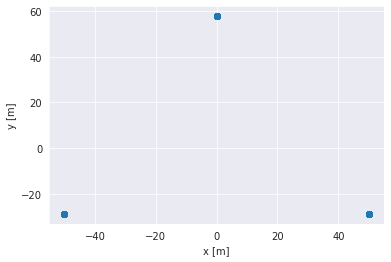

In [5]:
plt.scatter(module_positions[:, 0], module_positions[:, 1])
plt.xlabel("x [m]")
plt.ylabel("y [m]")

#### Definition of Generators

In [8]:


generator_factory = GeneratorFactory(det, gen_ph)

cascades_generator = generator_factory.create(
    "cascade", particle_id=11, log_minimal_energy=2, log_maximal_energy=5.5, rate=0.05
)

cascades_generator2 = generator_factory.create(
    "cascade", particle_id=11, log_minimal_energy=4, log_maximal_energy=5.5, rate=0.01
)

noise_generator = generator_factory.create("noise")

track_generator = generator_factory.create(
    'track',
    log_minimal_energy=2,
    log_maximal_energy=5.5,
    rate=0.02
)

generator_collection = GeneratorCollection(detector=det)

#generator_collection.add_generator(track_generator)
generator_collection.add_generator(cascades_generator)
generator_collection.add_generator(cascades_generator2)
generator_collection.add_generator(noise_generator)

This was easy. Let's generate events

In [9]:
event_collection = generator_collection.generate(
    start_time=0,
    end_time=500,
)

event_collection.get_info_as_panda().head()

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

,type,energy,time,pos_x,pos_y,pos_z,dir_x,dir_y,dir_z
0,cascade,131.783860,5.0,-95.585582,-43.394698,-377.209152,0.722848,0.644368,0.249562
1,cascade,116.950984,7.0,2.306750,-19.456780,-419.599252,0.691434,0.616364,-0.376848
2,cascade,18177.391376,19.0,-31.213457,74.047659,-373.557825,0.648237,0.577857,0.495852
3,cascade,7257.621263,91.0,-42.209868,-75.206314,355.490108,0.732342,0.652830,-0.193619
4,cascade,124.871772,100.0,39.474128,16.756848,-105.910200,0.633035,0.564305,0.529930


And save them

In [10]:
event_collection.save('./data/test')

### 1.2 Event Redistribution

Obviously it would be a waste to regenerate all events all the time. That's the reason we can redistribute existing events according to our preferences. As well, we show that it is possible to load from a folder we created

In [12]:
event_collection_to_redistribute = EventCollection.from_folder('data/test')

event_collection_to_redistribute.redistribute(0, 10000)

event_collection_to_redistribute.save('data/test2')

event_collection_to_redistribute.get_info_as_panda().head()

,type,energy,time,pos_x,pos_y,pos_z,dir_x,dir_y,dir_z
0,cascade,131.783860,1673,-95.585582,-43.394698,-377.209152,0.722848,0.644368,0.249562
1,cascade,116.950984,8435,2.306750,-19.456780,-419.599252,0.691434,0.616364,-0.376848
2,cascade,18177.391376,3218,-31.213457,74.047659,-373.557825,0.648237,0.577857,0.495852
3,cascade,7257.621263,5006,-42.209868,-75.206314,355.490108,0.732342,0.652830,-0.193619
4,cascade,124.871772,1319,39.474128,16.756848,-105.910200,0.633035,0.564305,0.529930


## 2. Dataset

Now that we got our events, we want machine learning usable datasets for them.

### General Workflow

In [13]:
event_collection_for_dataset = EventCollection.from_folder('data/test2')
dataset = SingleHistogramDataset.from_event_collection(event_collection, start_time=0,end_time=10000)

Let's check it out

In [14]:
dataset.labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [15]:
dataset.histogram

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

and save it

In [16]:
dataset.save('./data/test_dataset')

### Use Aggregation

It can be of use to pre-aggregate the module information

In [18]:
new_set = SingleHistogramDataset.load('./data/test_dataset', np.sum, {
    'axis': 0
})

new_set.histogram

array([1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.930e+02, 2.290e+02,
       5.661e+03, 1.012e+03, 2.656e+03, 1.373e+03, 7.650e+02, 8.300e+02,
       9.510e+02, 6.590e+02, 6.650e+02, 4.660e+02, 9.930e+02, 4.098e+03,
       1.666e+03, 1.386e+03, 6.360e+02, 1.687e+03, 1.608e+03, 1.873e+03,
       1.028e+03, 5.960e+02, 3.590e+02, 3.500e+02, 2.280e+02, 3.290e+02,
       1.610e+02, 1.640e+02, 1.310e+02, 6.700e+01, 2.900e+01, 3.000e+01,
       2.300e+01, 1.000e+01, 4.000e+00, 6.000e+00, 4.000e+00, 4.000e+00,
       1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 